# Correlation Networks analysis per band

In [2]:
from lrgsglib.core import *
#
cwd = Path.cwd()
while cwd.name != 'lrg_eegfc':
    %cd ..
    cwd = Path.cwd()
#
from src.lrg_eegfc.core import *
#
mat_path = Path('data') / 'stereoeeg_patients'
patients_list = [p.name for p in Path(mat_path).iterdir() 
                 if p.is_dir() and p.name.startswith('Pat_')]
#
phase_labels = ['rsPre', 'taskLearn', 'taskTest', 'rsPost']
param_keys_list = ['fs', 'fcutHigh', 'fcutLow', 'filter_order', 'NotchFilter', 'DataDimensions']

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


## Input Data

### Data import

In [3]:
ch_names = loadmat(mat_path / 'ChannelNames.mat')
ch_names = [name[0] for name in ch_names['ChannelNames'][0]]
ch_int_name_map = {i: name for i, name in enumerate(ch_names)}

In [4]:
data_dict = {}
for pat in [patients_list[1]]:
    data_dict[pat] = {}
    for phase in phase_labels:
        data_dict[pat][phase] = {}
        try:
            # Load the .mat file using scipy.io.loadmat
            # This is the preferred method for loading .mat files
            tmp_mat = loadmat(str(mat_path / pat / f'{phase}'))
        except Exception as e:
            # If loading fails, fall back to h5py
            print(f'{type(e).__name__} loading {pat} {phase}: {e}. ',
                  f'Continuing with h5py', end='\r', flush=True)
            tmp_mat = {}
            f = h5py.File(mat_path / pat / f'{phase}.mat')
            for k, v in f.items():
                tmp_mat[k] = np.array(v)
            pass
        data_dict[pat][phase]['data'] = tmp_mat['Data']
        tmp_shape = data_dict[pat][phase]['data'].shape
        if tmp_shape[0] > tmp_shape[1]:
            # Transpose the data if the first dimension is bigger
            data_dict[pat][phase]['data'] = data_dict[pat][phase]['data'].T
        try:
            # Extract the parameters from the loaded data
            # Check if 'Parameters' is in the loaded data
            # If not, skip to the next iteration
            for param in tmp_mat['Parameters'].dtype.names:
                if param in param_keys_list:
                    data_dict[pat][phase][param] = tmp_mat['Parameters'][param][0][0][0][0]
        except:
            print(f'No parameters found for {pat} {phase}', end='\r', flush=True)
            continue

In [6]:
np.load(Path('data') / 'correlations' / 'Pat_02' / f'rsPre_alpha_corr.npy')

array([[0.        , 0.78691533, 0.        , ..., 0.98194872, 0.9864815 ,
        0.97831659],
       [0.78691533, 0.        , 0.        , ..., 0.71423767, 0.7869197 ,
        0.69392767],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.98194872, 0.71423767, 0.        , ..., 0.        , 0.98194828,
        0.99207132],
       [0.9864815 , 0.7869197 , 0.        , ..., 0.98194828, 0.        ,
        0.97831593],
       [0.97831659, 0.69392767, 0.        , ..., 0.99207132, 0.97831593,
        0.        ]])

### Test on a specific Patient-Phase dataset

In [4]:
patient = 'Pat_02'
phase = 'rsPre'
filttime = -1

In [5]:
data_Pat_rsPre = data_dict[patient][phase]['data'][:, :filttime]
C = np.corrcoef(data_Pat_rsPre)
C_clean, eigvals_C, eigvecs_C, lambda_min, lambda_max, signal_mask = clean_correlation_matrix(C)

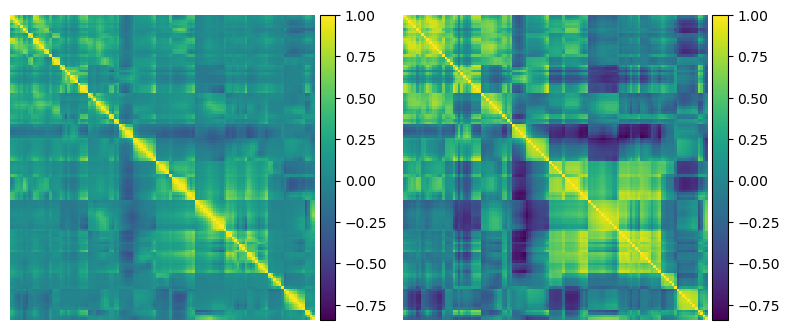

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
#
vmin = min(C.min(), C_clean.min())
vmax = max(C.max(), C_clean.max())
#
kwargs_imshow = dict(cmap='viridis', interpolation='none', vmin=vmin, vmax=vmax)
im = ax[0].imshow(C, **kwargs_imshow)
div, cax, clb = imshow_colorbar_caxdivider(im, ax[0])
im = ax[1].imshow(C_clean, **kwargs_imshow)
div, cax, clb = imshow_colorbar_caxdivider(im, ax[1])

for axx in ax:
    axx.axis('off')

fig.tight_layout()

### Testing random entries with Marchenko--Pastur

In [7]:
n_channels, time_steps = data_Pat_rsPre.shape
gamma = time_steps/n_channels
#
counts, bins = np.histogram(eigvals_C, density=True, bins=500)
MP_dist = marchenko_pastur(bins, gamma)

(0.0, 5.0)

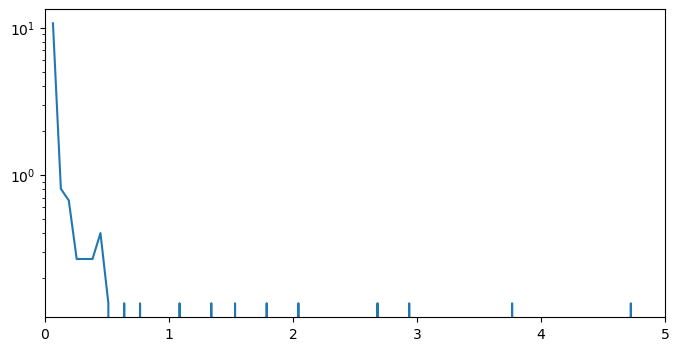

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(bins[1:], counts, label='Empirical')
ax.plot(bins, MP_dist, label='Marchenko-Pastur')
ax.set_yscale('log')
ax.set_xlim(left=0, right=5)

## Correlation Network

### Building the network by thresholding

In [ ]:
C_net = C.copy()
np.fill_diagonal(C_net, 0)
C_net = np.abs(C_net)
G = nx.from_numpy_array(C_net)
#
Th, Einf, Pinf = compute_threshold_stats(G)
Pinf_diff = np.diff(Pinf)
jumps = np.where(Pinf_diff != 0)[0]

Computing threshold stats: 100%|██████████| 400/400 [00:10<00:00, 39.09it/s]


In [10]:
not_in_giant = {}
for i,jump in enumerate(jumps):
    C_tmp = C_net.copy()
    C_tmp[C_tmp < Th[jump]*1.1] = 0
    G = nx.from_numpy_array(C_tmp)
    Gcc = max(nx.connected_components(G), key=len)
    Gcc = G.subgraph(Gcc)
    # get the nodes not in the giant component
    not_in_giant[i] = set(G.nodes()) - set(Gcc.nodes())
    if i > 0:
        not_in_giant[i] = not_in_giant[i]-not_in_giant[i-1]

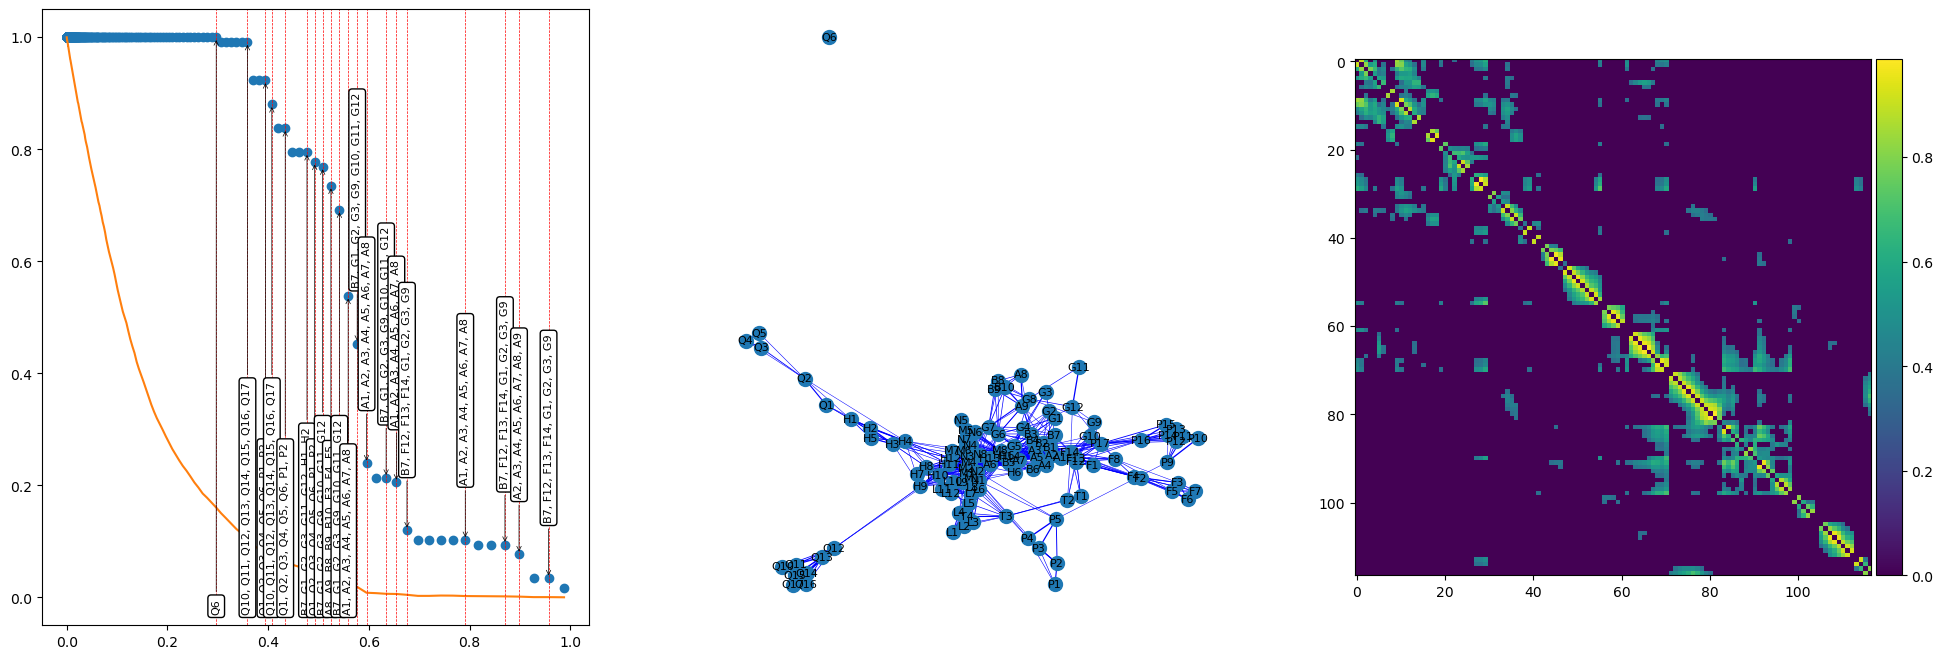

In [11]:
plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
#
ax[0].plot(Th, Pinf, 'o')
ax[0].plot(Th, Einf)
for i,jump in enumerate(jumps):
    ax[0].axvline(Th[jump], color='r', linestyle='--', lw=0.5)
    #annotate the vertical line with the names of the nodes not in the giant component
    #create a string with the names of the nodes not in the giant component and rotate 90 the text in annotate
    not_in_giant_str = ', '.join([ch_int_name_map[n] for n in not_in_giant[i]][:8])
    ax[0].annotate(not_in_giant_str, xy=(Th[jump], Pinf[jump]),
                xytext=(Th[jump], Pinf[jump]+0.1 if Pinf[jump] < 0.5 else -0.03),
                rotation=90,
                fontsize=8,
                ha='center',
                va='bottom',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'),
                arrowprops=dict(arrowstyle="->", lw=0.5, color='black'))
#
C_tmp = C_net.copy()
C_tmp[C_tmp < Th[jumps[1]]] = 0
G = nx.from_numpy_array(C_tmp)
widths = [ G[u][v]['weight'] for u, v in G.edges()]
edge_colors = ['red' if d['weight'] < 0 else 'blue' for u, v, d in G.edges(data=True)]
nx.draw(G, ax=ax[1], node_size=100, width=widths, edge_color=edge_colors, with_labels=True, labels=ch_int_name_map,font_size=8)
#
kwargs_imshow = dict(cmap='viridis', interpolation='none', vmin=C_tmp.min(), vmax=C_tmp.max())
im = ax[2].imshow(C_tmp, **kwargs_imshow)
div, cax, clb = imshow_colorbar_caxdivider(im, ax[2])

### Building the correlation network by band

In [1]:
sample_rate = 2048
filter_order = 4
corr_nets = {}
corr_graphs = {}
for band_name, (low, high) in BRAIN_BANDS.items():
    # 4a) filter all channels at once
    filt = bandpass_sos(data_Pat_rsPre, low, high, sample_rate, filter_order)
    C_filt = np.abs(np.corrcoef(filt))
    np.fill_diagonal(C_filt, 0)
    corr_nets[band_name] = C_filt
    corr_graphs[band_name] = nx.from_numpy_array(C_filt)

NameError: name 'BRAIN_BANDS' is not defined

Computing threshold stats: 100%|██████████| 100/100 [00:02<00:00, 43.13it/s]


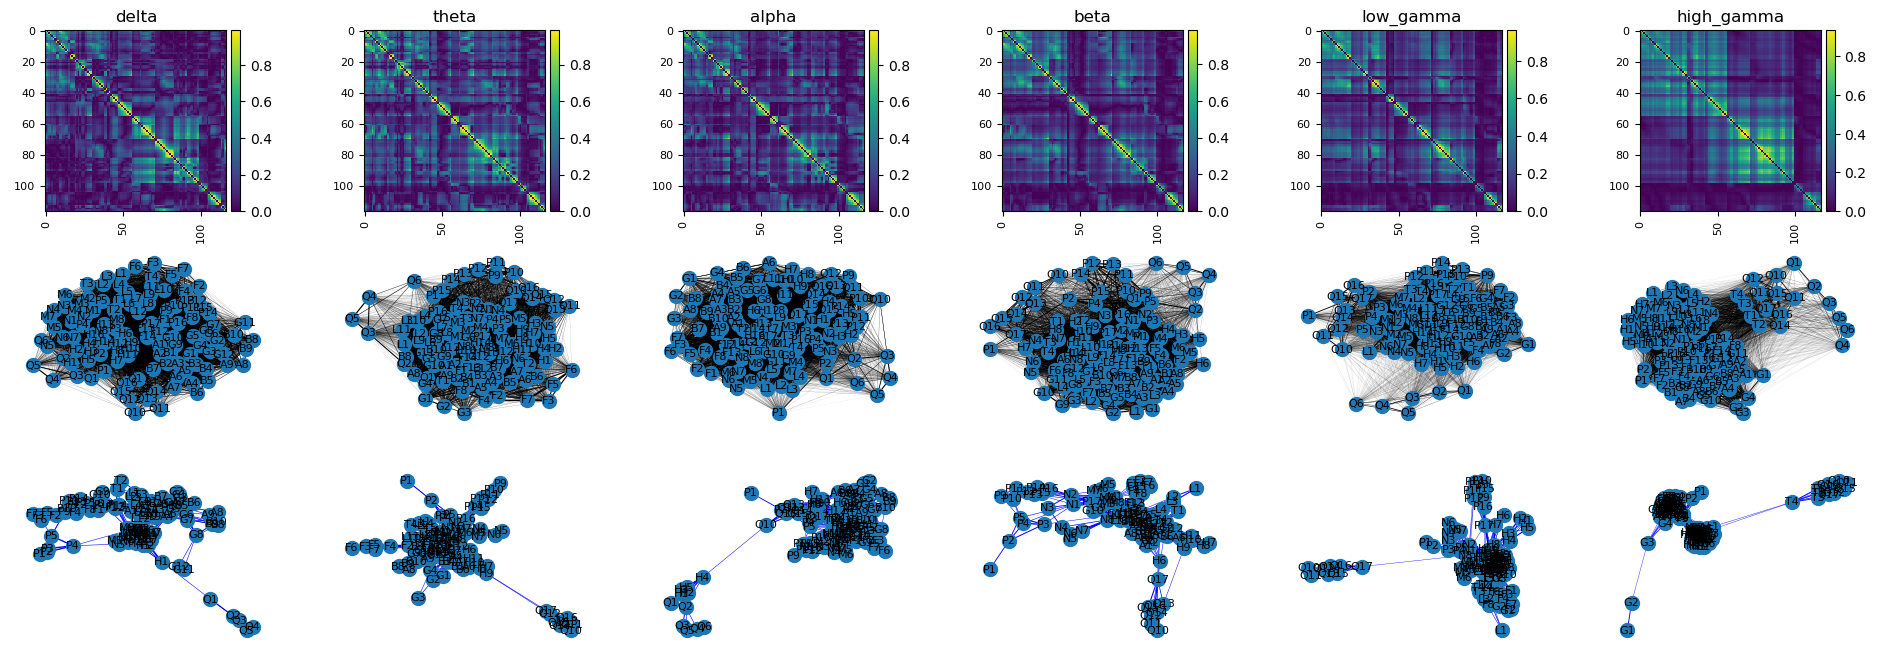

In [31]:
corr_graphs_filt = {}
corr_nets_filt = {}

fig, ax = plt.subplots(3, len(BRAIN_BANDS), figsize=(24, 8))
for i, (band_name, C_filt) in enumerate(corr_nets.items()):
    kwargs_imshow = dict(cmap='viridis', interpolation='none', vmin=C_filt.min(), vmax=C_filt.max())
    im = ax[0][i].imshow(C_filt, **kwargs_imshow)
    div, cax, clb = imshow_colorbar_caxdivider(im, ax[0][i])
    ax[0][i].set_title(band_name)
    for tick in ax[0][i].get_xticklabels():
        tick.set_rotation(90)
        tick.set_fontsize(8)
        tick.set_color('black')
    for tick in ax[0][i].get_yticklabels():
        tick.set_fontsize(8)
        tick.set_color('black')
for i, (band_name, C_filt) in enumerate(corr_nets.items()):
    G = corr_graphs[band_name]
    widths = [ G[u][v]['weight'] for u, v in G.edges()]
    nx.draw(G, width=widths, ax=ax[1][i], node_size=100, with_labels=True, labels=ch_int_name_map,font_size=8)
for i, (band_name, C_filt) in enumerate(corr_nets.items()):
    G = corr_graphs[band_name]
    Th, Einf, Pinf = compute_threshold_stats(G, n_points=100)
    Pinf_diff = np.diff(Pinf)
    jumps = np.where(Pinf_diff != 0)[0]
    C_tmp = C_filt.copy()
    C_tmp[C_tmp < Th[jumps[1]]] = 0
    G = nx.from_numpy_array(C_tmp)
    corr_nets_filt[band_name] = C_tmp
    corr_graphs_filt[band_name] = G
    Gcc = max(nx.connected_components(G), key=len)
    Gcc = G.subgraph(Gcc)
    widths = [ Gcc[u][v]['weight'] for u, v in Gcc.edges()]
    nx.draw(Gcc, ax=ax[2][i], node_size=100, width=widths, edge_color=edge_colors, with_labels=True, labels={k: ch_int_name_map[k] for k in list(Gcc.nodes())},font_size=8)

In [50]:
oneband = list(BRAIN_BANDS.keys())[0]
GG = corr_graphs_filt[oneband]
GG = get_giant_component(GG)
CC = corr_nets_filt[oneband]

In [51]:
#
networkEntropy = entropy(GG, t1=-3, t2=5, steps=400)
tau_scale = networkEntropy[-1]
speC = networkEntropy[1]/networkEntropy[1].max()
Sm1 = networkEntropy[0]/networkEntropy[0].max()
#

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/core.py:645: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/core.py:645: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


In [58]:
spectrum, L, rho, Trho, tau = compute_laplacian_properties(GG, tau=None)
dists = squareform(Trho)
linkage_matrix, label_list, tmax = compute_normalized_linkage(dists, GG, method='ward')
FlatClusteringTh , *_ = compute_optimal_threshold(linkage_matrix)

In [59]:
# FlatClusteringTh =1e-2
optimal_clusters = fcluster(linkage_matrix, t=FlatClusteringTh, criterion='distance')

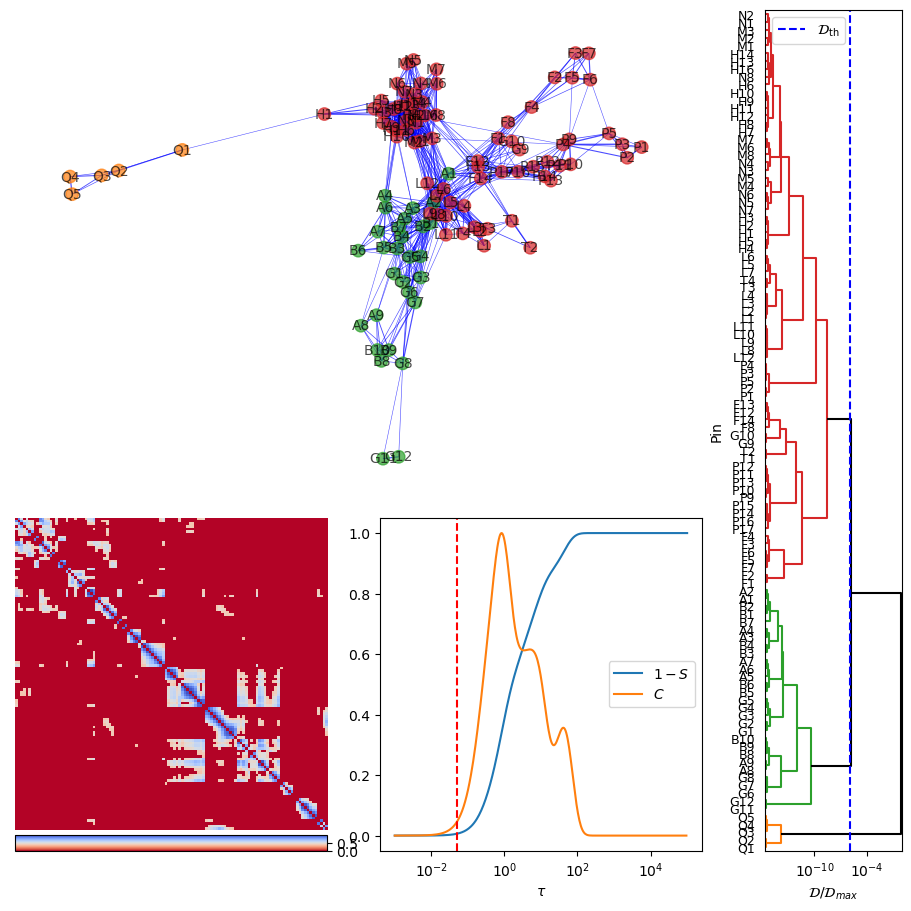

In [ ]:
fig = plt.figure(constrained_layout=True,figsize=(9, 9))
#
ax_dict = fig.subplot_mosaic(
    """
    DDDDE
    DDDDE
    DDDDE
    BBCCE
    BBCCE
    """
)
#
im = ax_dict['B'].imshow(CC, cmap='coolwarm_r', interpolation='none')
imshow_colorbar_caxdivider(im, ax_dict['B'], position='bottom')#, orientation='horizontal')
ax_dict['B'].axis('off')
#
ax_dict['C'].plot(tau_scale, Sm1, label=r'$1-S$')
ax_dict['C'].plot(tau_scale[:-1], speC, label=r'$C$')
ax_dict['C'].set_xscale('log')
ax_dict['C'].legend()
ax_dict['C'].set_xlabel(r"$\tau$")
ax_dict['C'].axvline(tau, color = 'r', 
    linestyle = '--', )
#
relabel_list = [ch_int_name_map[nd] for nd in label_list]
dendro = dendrogram(linkage_matrix, ax=ax_dict['E'], 
                    color_threshold=FlatClusteringTh,
    above_threshold_color='k', leaf_font_size=9,
    labels=relabel_list, orientation='right')
tmin = linkage_matrix[::, 2][0] - 0.2*linkage_matrix[::, 2][0]
tmax = linkage_matrix[::, 2][-1] + 0.1*linkage_matrix[::, 2][-1]
#
ax_dict['E'].axvline(
    FlatClusteringTh, 
    color = 'b', 
    linestyle = '--', 
    label=r"$\mathcal{D}_{\rm th}$")
ax_dict['E'].set_xscale('log')
ax_dict['E'].set_xlim(tmin,tmax)
ax_dict['E'].legend()
ax_dict['E'].set_xlabel(r"$\mathcal{D}/\mathcal{D}_{max}$")
ax_dict['E'].set_ylabel('Pin')
#
leaf_label_colors = {label: color for label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}
node_colors = [leaf_label_colors[label] for label in relabel_list]

widths = [GG[u][v]['weight'] for u, v in GG.edges()]
ch_int_name_map_ = {k: ch_int_name_map[k] for k in list(GG.nodes())}

pos = nx.spring_layout(GG, seed=5)

#
nx.draw(GG, pos=pos, ax=ax_dict['D'], node_size=80, font_size=10, width=widths, edge_color=edge_colors, node_color=node_colors,alpha=0.7, with_labels=True, labels=ch_int_name_map_, )
# plt.margins(0.0)
#
